# Heart Disease - Causality Explorer Interface

**Tema:** Analisis Faktor Penyebab Penyakit Jantung (Healthcare)

**Tujuan:** Membuat User Causality Explorer Interface dengan tiga aspek:
1. Dimension View
2. Table View
3. Causal Graph View

**Dataset:** Heart Disease UCI Dataset (Kaggle/UCI Machine Learning Repository)

**Jumlah Data:** 1,025 records, 14 variabel

---
## 1. Setup Environment

In [ ]:
# Cell 1: Install & Import Libraries
!pip install dowhy networkx plotly -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from dowhy import CausalModel
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✓ Library berhasil diimport")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.1/403.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 72.8 MB/s eta 0:00:00
✓ Library berhasil diimport


In [ ]:
# Cell 2: Load Data
from google.colab import files
import io

print("Upload file heart.csv")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"\n✓ Data loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"Columns: {df.columns.tolist()}")

Upload file heart.csv


Saving heart.csv to heart.csv

✓ Data loaded: 1025 rows, 14 columns
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


---
## 2. Data Understanding & Preparation

In [ ]:
# Cell 3: Data Overview
print("="*60)
print("DATA OVERVIEW")
print("="*60)

print("\n[1] Informasi Dataset")
print(df.info())

print("\n[2] Preview Data (5 baris pertama)")
display(df.head())

print("\n[3] Deskripsi Variabel:")
variable_desc = {
    'age': 'Usia pasien (tahun)',
    'sex': 'Jenis kelamin (1=male, 0=female)',
    'cp': 'Chest pain type (0-3)',
    'trestbps': 'Resting blood pressure (mm Hg)',
    'chol': 'Serum cholesterol (mg/dl)',
    'fbs': 'Fasting blood sugar > 120 mg/dl (1=true, 0=false)',
    'restecg': 'Resting ECG results (0-2)',
    'thalach': 'Maximum heart rate achieved',
    'exang': 'Exercise induced angina (1=yes, 0=no)',
    'oldpeak': 'ST depression induced by exercise',
    'slope': 'Slope of peak exercise ST segment (0-2)',
    'ca': 'Number of major vessels colored by fluoroscopy (0-4)',
    'thal': 'Thalassemia (0-3)',
    'target': 'Heart disease diagnosis (1=disease, 0=no disease)'
}

for var, desc in variable_desc.items():
    print(f"  • {var}: {desc}")

DATA OVERVIEW

[1] Informasi Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

[2] Preview Data (5 baris pertama)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



[3] Deskripsi Variabel:
  • age: Usia pasien (tahun)
  • sex: Jenis kelamin (1=male, 0=female)
  • cp: Chest pain type (0-3)
  • trestbps: Resting blood pressure (mm Hg)
  • chol: Serum cholesterol (mg/dl)
  • fbs: Fasting blood sugar > 120 mg/dl (1=true, 0=false)
  • restecg: Resting ECG results (0-2)
  • thalach: Maximum heart rate achieved
  • exang: Exercise induced angina (1=yes, 0=no)
  • oldpeak: ST depression induced by exercise
  • slope: Slope of peak exercise ST segment (0-2)
  • ca: Number of major vessels colored by fluoroscopy (0-4)
  • thal: Thalassemia (0-3)
  • target: Heart disease diagnosis (1=disease, 0=no disease)


In [ ]:
# Cell 4: Data Cleaning
print("="*60)
print("DATA CLEANING")
print("="*60)

# [1] Cek Missing Values
print("\n[1] Missing Values Analysis")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0]
if len(missing_df) > 0:
    display(missing_df)
else:
    print("✓ Tidak ada missing values")

# [2] Cek Duplikat
print("\n[2] Duplicate Check")
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"⚠ Ditemukan {duplicates} baris duplikat")
    df = df.drop_duplicates()
    print(f"✓ Duplikat dihapus. Data sekarang: {len(df)} rows")
else:
    print(f"✓ Tidak ada duplikat ({len(df)} rows)")

# [3] Cek Tipe Data
print("\n[3] Data Types")
print(df.dtypes)

# [4] Summary
print("\n" + "="*60)
print("DATA CLEANING SUMMARY")
print("="*60)
print(f"✓ Total Records: {len(df)}")
print(f"✓ Total Columns: {len(df.columns)}")
print(f"✓ Missing Values: {df.isnull().sum().sum()}")
print(f"✓ Data siap untuk analisis!")

DATA CLEANING

[1] Missing Values Analysis
✓ Tidak ada missing values

[2] Duplicate Check
⚠ Ditemukan 723 baris duplikat
✓ Duplikat dihapus. Data sekarang: 302 rows

[3] Data Types
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

DATA CLEANING SUMMARY
✓ Total Records: 302
✓ Total Columns: 14
✓ Missing Values: 0
✓ Data siap untuk analisis!


In [ ]:
# Cell 5: Define Variable Types
print("="*60)
print("VARIABLE CLASSIFICATION")
print("="*60)

# Klasifikasi variabel
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
target_col = 'target'

print(f"\nNumerical Variables ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical Variables ({len(categorical_cols)}): {categorical_cols}")
print(f"Target Variable: {target_col}")

# Target distribution
print("\n[Target Distribution]")
target_dist = df[target_col].value_counts()
target_pct = df[target_col].value_counts(normalize=True) * 100
print(f"  0 (No Disease): {target_dist[0]} ({target_pct[0]:.1f}%)")
print(f"  1 (Disease): {target_dist[1]} ({target_pct[1]:.1f}%)")

VARIABLE CLASSIFICATION

Numerical Variables (5): ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical Variables (8): ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Target Variable: target

[Target Distribution]
  0 (No Disease): 138 (45.7%)
  1 (Disease): 164 (54.3%)


---
## 3. DIMENSION VIEW

DIMENSION VIEW

[1] Distribusi Variabel Numerik


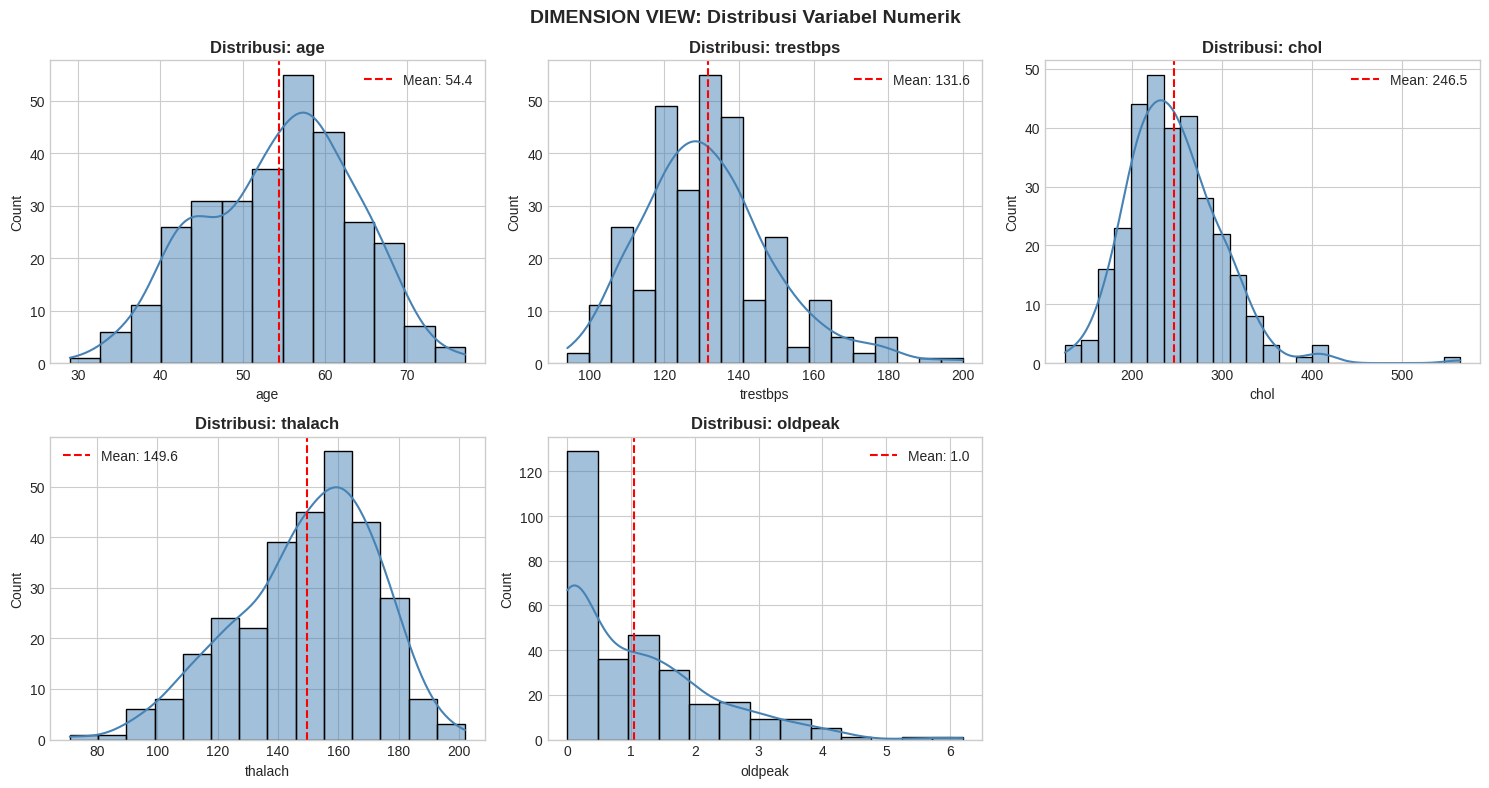

In [ ]:
# Cell 6: DIMENSION VIEW - Distribusi Variabel Numerik
print("="*60)
print("DIMENSION VIEW")
print("="*60)

print("\n[1] Distribusi Variabel Numerik")

n_cols = len(numerical_cols)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='steelblue')
    axes[i].axvline(df[col].mean(), color='red', linestyle='--',
                    label=f'Mean: {df[col].mean():.1f}')
    axes[i].set_title(f'Distribusi: {col}', fontweight='bold')
    axes[i].legend()

# Hapus subplot kosong
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('DIMENSION VIEW: Distribusi Variabel Numerik', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


[2] Distribusi Variabel Kategorikal


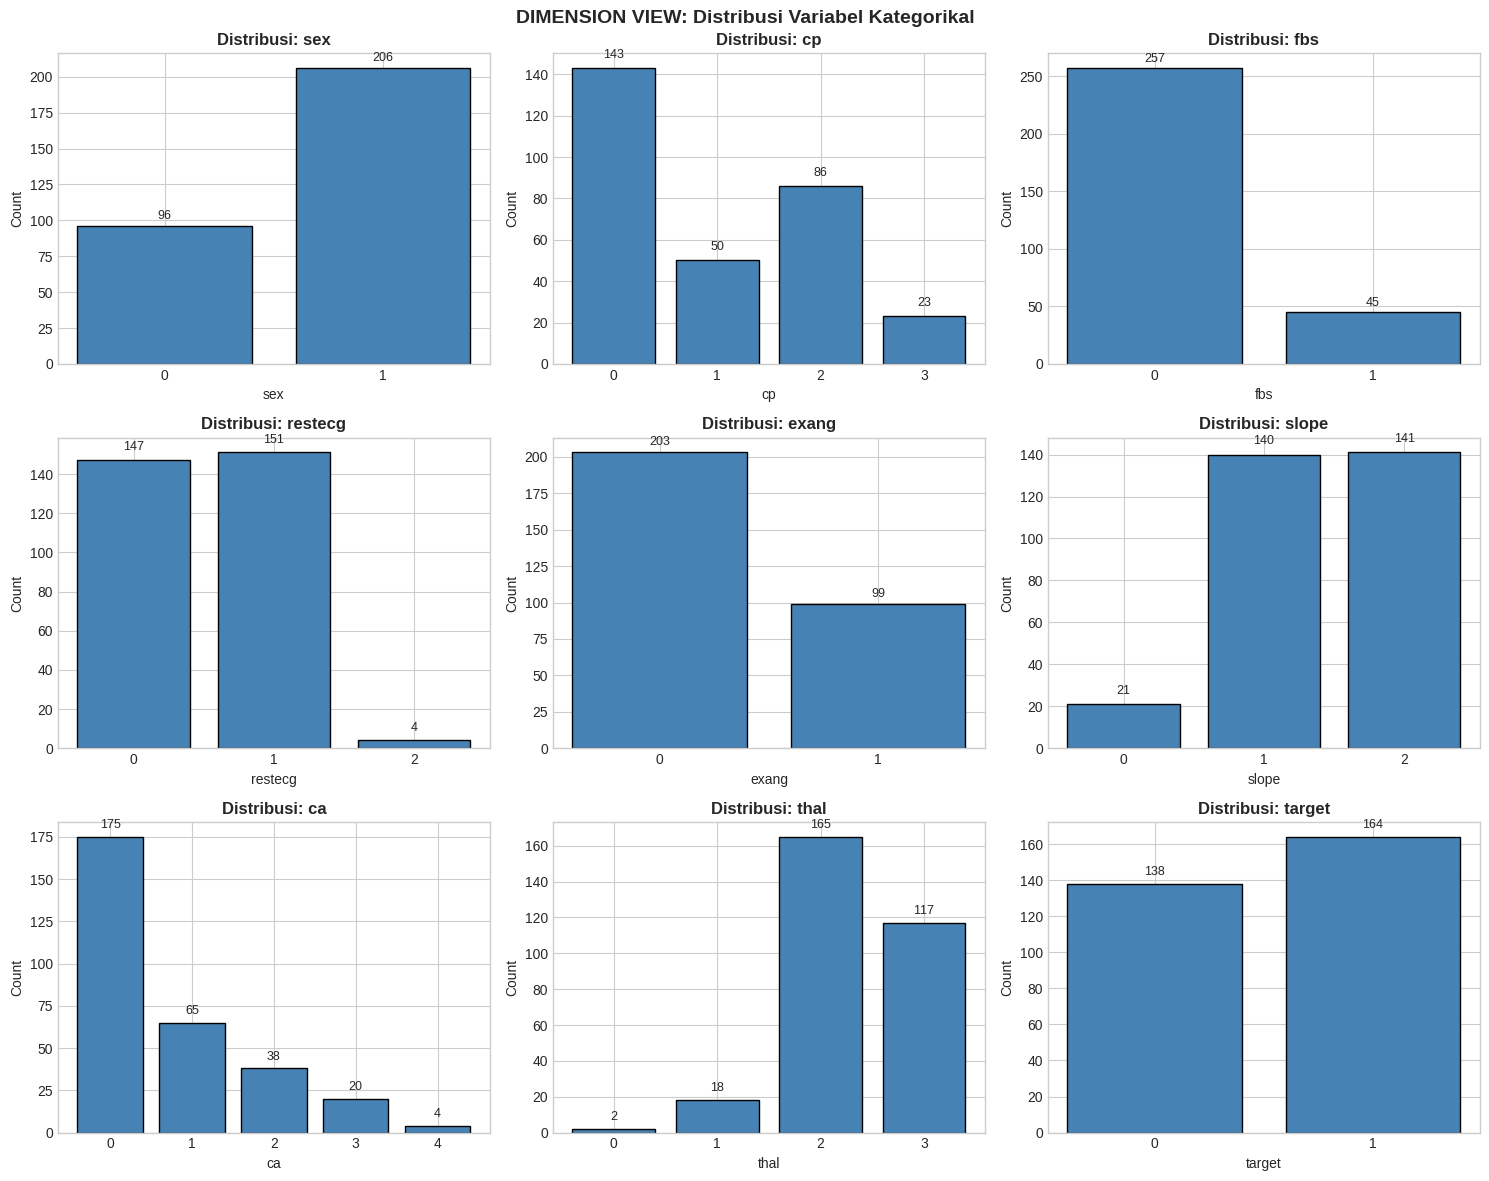

In [ ]:
# Cell 7: DIMENSION VIEW - Distribusi Variabel Kategorikal
print("\n[2] Distribusi Variabel Kategorikal")

n_cat = len(categorical_cols) + 1  # +1 untuk target
n_rows = (n_cat + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten()

all_cat = categorical_cols + [target_col]

for i, col in enumerate(all_cat):
    counts = df[col].value_counts().sort_index()
    bars = axes[i].bar(counts.index.astype(str), counts.values, color='steelblue', edgecolor='black')
    axes[i].set_title(f'Distribusi: {col}', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

    # Add value labels
    for bar, val in zip(bars, counts.values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                     str(val), ha='center', fontsize=9)

# Hapus subplot kosong
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('DIMENSION VIEW: Distribusi Variabel Kategorikal', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


[3] Correlation Heatmap


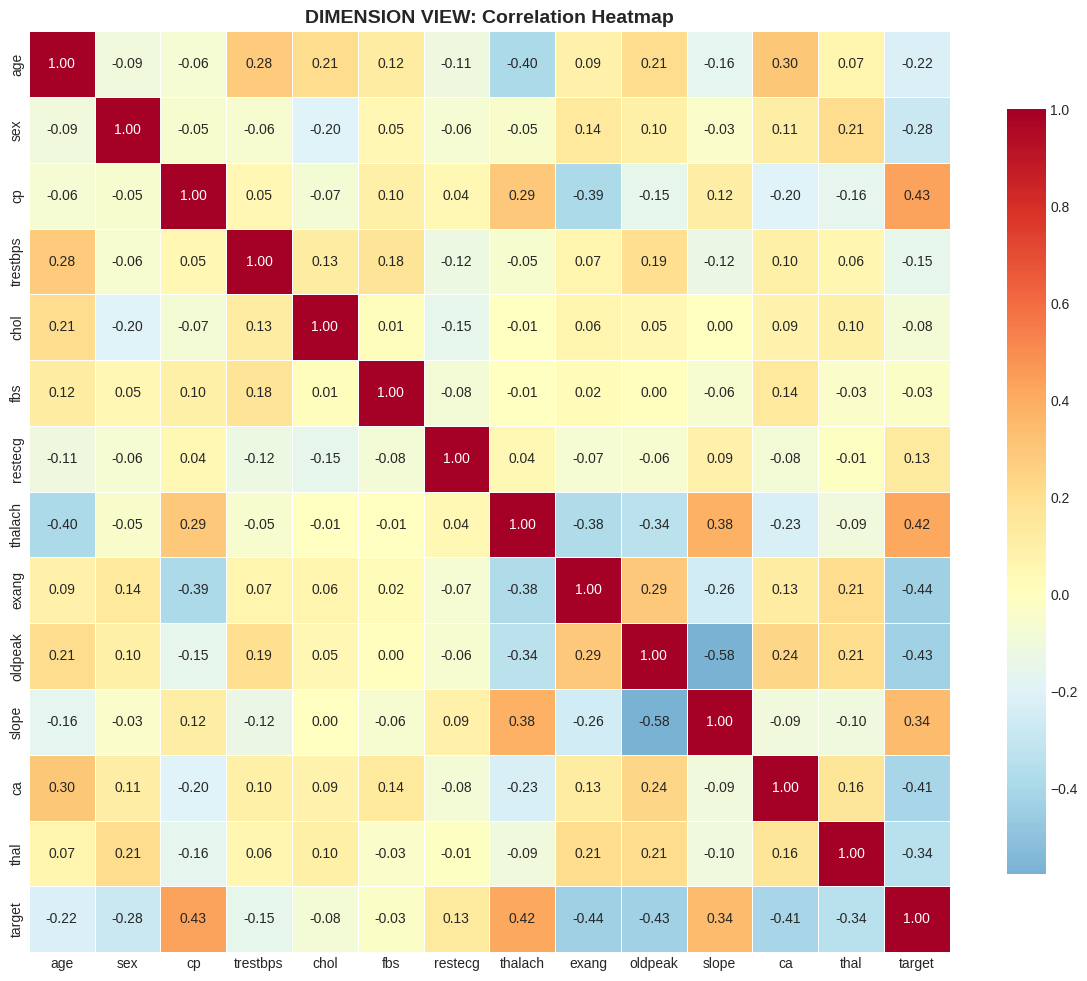


[Korelasi Tertinggi dengan Target (Heart Disease)]
  • exang: -0.436
  • cp: +0.432
  • oldpeak: -0.429
  • thalach: +0.420
  • ca: -0.409


In [ ]:
# Cell 8: DIMENSION VIEW - Correlation Heatmap
print("\n[3] Correlation Heatmap")

plt.figure(figsize=(12, 10))
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8})

plt.title('DIMENSION VIEW: Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with target
print("\n[Korelasi Tertinggi dengan Target (Heart Disease)]")
target_corr = corr_matrix['target'].drop('target').abs().sort_values(ascending=False)
for var, corr in target_corr.head(5).items():
    direction = '+' if corr_matrix.loc[var, 'target'] > 0 else '-'
    print(f"  • {var}: {direction}{corr:.3f}")


[4] Boxplot Comparison by Heart Disease Status


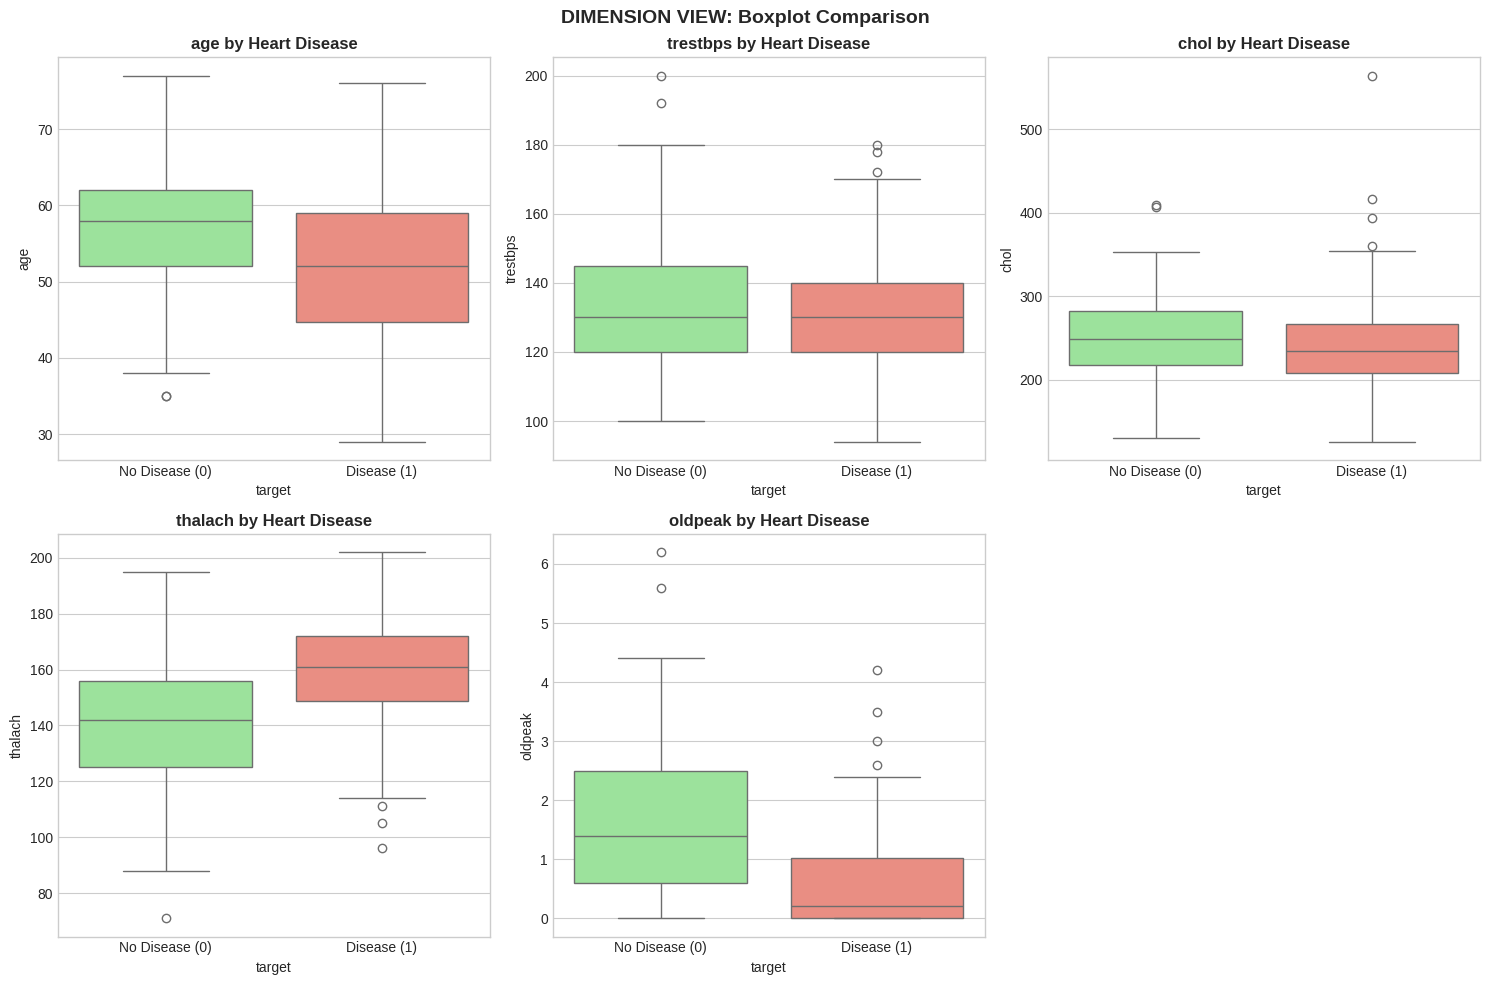

In [ ]:
# Cell 9: DIMENSION VIEW - Boxplot by Target
print("\n[4] Boxplot Comparison by Heart Disease Status")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='target', y=col, ax=axes[i], palette=['lightgreen', 'salmon'])
    axes[i].set_title(f'{col} by Heart Disease', fontweight='bold')
    axes[i].set_xticklabels(['No Disease (0)', 'Disease (1)'])

# Hapus subplot kosong
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('DIMENSION VIEW: Boxplot Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 10: DIMENSION VIEW - 3D Interactive Plot
print("\n[5] 3D Interactive Visualization")

fig = px.scatter_3d(df, x='age', y='chol', z='thalach',
                    color='target',
                    color_discrete_map={0: 'green', 1: 'red'},
                    labels={'target': 'Heart Disease'},
                    title='DIMENSION VIEW: 3D Visualization (Age, Cholesterol, Max Heart Rate)')

fig.update_layout(height=600)
fig.show()


[5] 3D Interactive Visualization


---
## 4. TABLE VIEW

In [ ]:
# Cell 11: TABLE VIEW - Data Summary
print("="*60)
print("TABLE VIEW")
print("="*60)

print("\n[1] Data Summary")
print(f"Total Records: {len(df)}")
print(f"Total Columns: {len(df.columns)}")
print(f"Missing Values: {df.isnull().sum().sum()}")

print("\n[2] Statistik Deskriptif - Variabel Numerik")
display(df[numerical_cols].describe().round(2))

TABLE VIEW

[1] Data Summary
Total Records: 302
Total Columns: 14
Missing Values: 0

[2] Statistik Deskriptif - Variabel Numerik


,age,trestbps,chol,thalach,oldpeak
count,302.00,302.00,302.00,302.00,302.00
mean,54.42,131.60,246.50,149.57,1.04
std,9.05,17.56,51.75,22.90,1.16
min,29.00,94.00,126.00,71.00,0.00
25%,48.00,120.00,211.00,133.25,0.00
50%,55.50,130.00,240.50,152.50,0.80
75%,61.00,140.00,274.75,166.00,1.60
max,77.00,200.00,564.00,202.00,6.20


In [ ]:
# Cell 12: TABLE VIEW - Categorical Summary
print("\n[3] Ringkasan Variabel Kategorikal")

for col in categorical_cols + [target_col]:
    print(f"\n{col}:")
    summary = pd.DataFrame({
        'Count': df[col].value_counts().sort_index(),
        'Percent': (df[col].value_counts(normalize=True).sort_index() * 100).round(1)
    })
    display(summary)


[3] Ringkasan Variabel Kategorikal

sex:


,Count,Percent
sex,,
0,96,31.8
1,206,68.2



cp:


,Count,Percent
cp,,
0,143,47.4
1,50,16.6
2,86,28.5
3,23,7.6



fbs:


,Count,Percent
fbs,,
0,257,85.1
1,45,14.9



restecg:


,Count,Percent
restecg,,
0,147,48.7
1,151,50.0
2,4,1.3



exang:


,Count,Percent
exang,,
0,203,67.2
1,99,32.8



slope:


,Count,Percent
slope,,
0,21,7.0
1,140,46.4
2,141,46.7



ca:


,Count,Percent
ca,,
0,175,57.9
1,65,21.5
2,38,12.6
3,20,6.6
4,4,1.3



thal:


,Count,Percent
thal,,
0,2,0.7
1,18,6.0
2,165,54.6
3,117,38.7



target:


,Count,Percent
target,,
0,138,45.7
1,164,54.3


In [ ]:
# Cell 13: TABLE VIEW - Crosstab Analysis
print("\n[4] Crosstab Analysis")

# Sex vs Target
print("\nSex vs Heart Disease:")
crosstab_sex = pd.crosstab(df['sex'], df['target'], margins=True)
crosstab_sex.index = ['Female (0)', 'Male (1)', 'Total']
crosstab_sex.columns = ['No Disease', 'Disease', 'Total']
display(crosstab_sex)

# Chest Pain Type vs Target
print("\nChest Pain Type vs Heart Disease:")
crosstab_cp = pd.crosstab(df['cp'], df['target'], margins=True)
crosstab_cp.columns = ['No Disease', 'Disease', 'Total']
display(crosstab_cp)

# Fasting Blood Sugar vs Target
print("\nFasting Blood Sugar vs Heart Disease:")
crosstab_fbs = pd.crosstab(df['fbs'], df['target'], margins=True)
crosstab_fbs.index = ['FBS ≤ 120 (0)', 'FBS > 120 (1)', 'Total']
crosstab_fbs.columns = ['No Disease', 'Disease', 'Total']
display(crosstab_fbs)


[4] Crosstab Analysis

Sex vs Heart Disease:


,No Disease,Disease,Total
Female (0),24,72,96
Male (1),114,92,206
Total,138,164,302



Chest Pain Type vs Heart Disease:


,No Disease,Disease,Total
cp,,,
0,104,39,143
1,9,41,50
2,18,68,86
3,7,16,23
All,138,164,302



Fasting Blood Sugar vs Heart Disease:


,No Disease,Disease,Total
FBS ≤ 120 (0),116,141,257
FBS > 120 (1),22,23,45
Total,138,164,302


In [ ]:
# Cell 14: TABLE VIEW - Correlation Matrix Table
print("\n[5] Correlation Matrix (Table Format)")
display(df.corr().round(3))


[5] Correlation Matrix (Table Format)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000,-0.095,-0.063,0.283,0.207,0.119,-0.112,-0.395,0.093,0.206,-0.164,0.302,0.065,-0.221
sex,-0.095,1.000,-0.052,-0.058,-0.196,0.046,-0.060,-0.046,0.143,0.098,-0.033,0.113,0.211,-0.284
cp,-0.063,-0.052,1.000,0.046,-0.073,0.096,0.042,0.293,-0.393,-0.147,0.117,-0.195,-0.160,0.432
trestbps,0.283,-0.058,0.046,1.000,0.125,0.178,-0.115,-0.048,0.069,0.195,-0.123,0.099,0.063,-0.146
chol,0.207,-0.196,-0.073,0.125,1.000,0.011,-0.148,-0.005,0.064,0.050,0.000,0.087,0.097,-0.081
fbs,0.119,0.046,0.096,0.178,0.011,1.000,-0.083,-0.007,0.025,0.005,-0.059,0.145,-0.033,-0.027
restecg,-0.112,-0.060,0.042,-0.115,-0.148,-0.083,1.000,0.041,-0.069,-0.056,0.090,-0.083,-0.010,0.135
thalach,-0.395,-0.046,0.293,-0.048,-0.005,-0.007,0.041,1.000,-0.377,-0.342,0.385,-0.228,-0.095,0.420
exang,0.093,0.143,-0.393,0.069,0.064,0.025,-0.069,-0.377,1.000,0.287,-0.256,0.125,0.206,-0.436
oldpeak,0.206,0.098,-0.147,0.195,0.050,0.005,-0.056,-0.342,0.287,1.000,-0.576,0.237,0.209,-0.429


In [ ]:
# Cell 15: TABLE VIEW - Mean by Target Group
print("\n[6] Mean Values by Heart Disease Status")

mean_by_target = df.groupby('target')[numerical_cols].mean().round(2)
mean_by_target.index = ['No Disease (0)', 'Disease (1)']
display(mean_by_target)

print("\nInterpretasi:")
for col in numerical_cols:
    diff = mean_by_target.loc['Disease (1)', col] - mean_by_target.loc['No Disease (0)', col]
    direction = "lebih tinggi" if diff > 0 else "lebih rendah"
    print(f"  • {col}: Pasien dengan penyakit jantung memiliki nilai {direction} ({diff:+.2f})")


[6] Mean Values by Heart Disease Status


,age,trestbps,chol,thalach,oldpeak
No Disease (0),56.60,134.40,251.09,139.10,1.59
Disease (1),52.59,129.25,242.64,158.38,0.59



Interpretasi:
  • age: Pasien dengan penyakit jantung memiliki nilai lebih rendah (-4.01)
  • trestbps: Pasien dengan penyakit jantung memiliki nilai lebih rendah (-5.15)
  • chol: Pasien dengan penyakit jantung memiliki nilai lebih rendah (-8.45)
  • thalach: Pasien dengan penyakit jantung memiliki nilai lebih tinggi (+19.28)
  • oldpeak: Pasien dengan penyakit jantung memiliki nilai lebih rendah (-1.00)


---
## 5. CAUSAL GRAPH VIEW

In [ ]:
# Cell 16: CAUSAL GRAPH VIEW - Define Causal Edges
print("="*60)
print("CAUSAL GRAPH VIEW")
print("="*60)

# Define causal edges berdasarkan domain knowledge medis
edges = [
    # Age sebagai root cause (mempengaruhi banyak variabel)
    ('age', 'trestbps'),      # Usia -> Tekanan darah
    ('age', 'chol'),          # Usia -> Kolesterol
    ('age', 'thalach'),       # Usia -> Max heart rate
    ('age', 'target'),        # Usia -> Penyakit jantung

    # Sex mempengaruhi risiko
    ('sex', 'chol'),          # Jenis kelamin -> Kolesterol
    ('sex', 'trestbps'),      # Jenis kelamin -> Tekanan darah
    ('sex', 'target'),        # Jenis kelamin -> Penyakit jantung

    # Faktor risiko utama -> Target
    ('chol', 'target'),       # Kolesterol -> Penyakit jantung
    ('trestbps', 'target'),   # Tekanan darah -> Penyakit jantung
    ('fbs', 'target'),        # Gula darah -> Penyakit jantung
    ('thalach', 'target'),    # Max heart rate -> Penyakit jantung

    # Gejala klinis -> Target
    ('cp', 'target'),         # Chest pain -> Penyakit jantung
    ('exang', 'target'),      # Exercise angina -> Penyakit jantung
    ('oldpeak', 'target'),    # ST depression -> Penyakit jantung
    ('slope', 'target'),      # ST slope -> Penyakit jantung
    ('ca', 'target'),         # Major vessels -> Penyakit jantung
    ('thal', 'target'),       # Thalassemia -> Penyakit jantung
    ('restecg', 'target'),    # Resting ECG -> Penyakit jantung

    # Hubungan antar faktor risiko
    ('fbs', 'chol'),          # Gula darah -> Kolesterol
    ('chol', 'trestbps'),     # Kolesterol -> Tekanan darah
    ('trestbps', 'thalach'),  # Tekanan darah -> Max heart rate
]

print(f"\nCausal edges: {len(edges)}")
print("\nDaftar hubungan kausal:")
for i, (cause, effect) in enumerate(edges, 1):
    print(f"  {i:2}. {cause} → {effect}")

CAUSAL GRAPH VIEW

Causal edges: 21

Daftar hubungan kausal:
   1. age → trestbps
   2. age → chol
   3. age → thalach
   4. age → target
   5. sex → chol
   6. sex → trestbps
   7. sex → target
   8. chol → target
   9. trestbps → target
  10. fbs → target
  11. thalach → target
  12. cp → target
  13. exang → target
  14. oldpeak → target
  15. slope → target
  16. ca → target
  17. thal → target
  18. restecg → target
  19. fbs → chol
  20. chol → trestbps
  21. trestbps → thalach



[1] Theory-Based Causal Graph (Static)


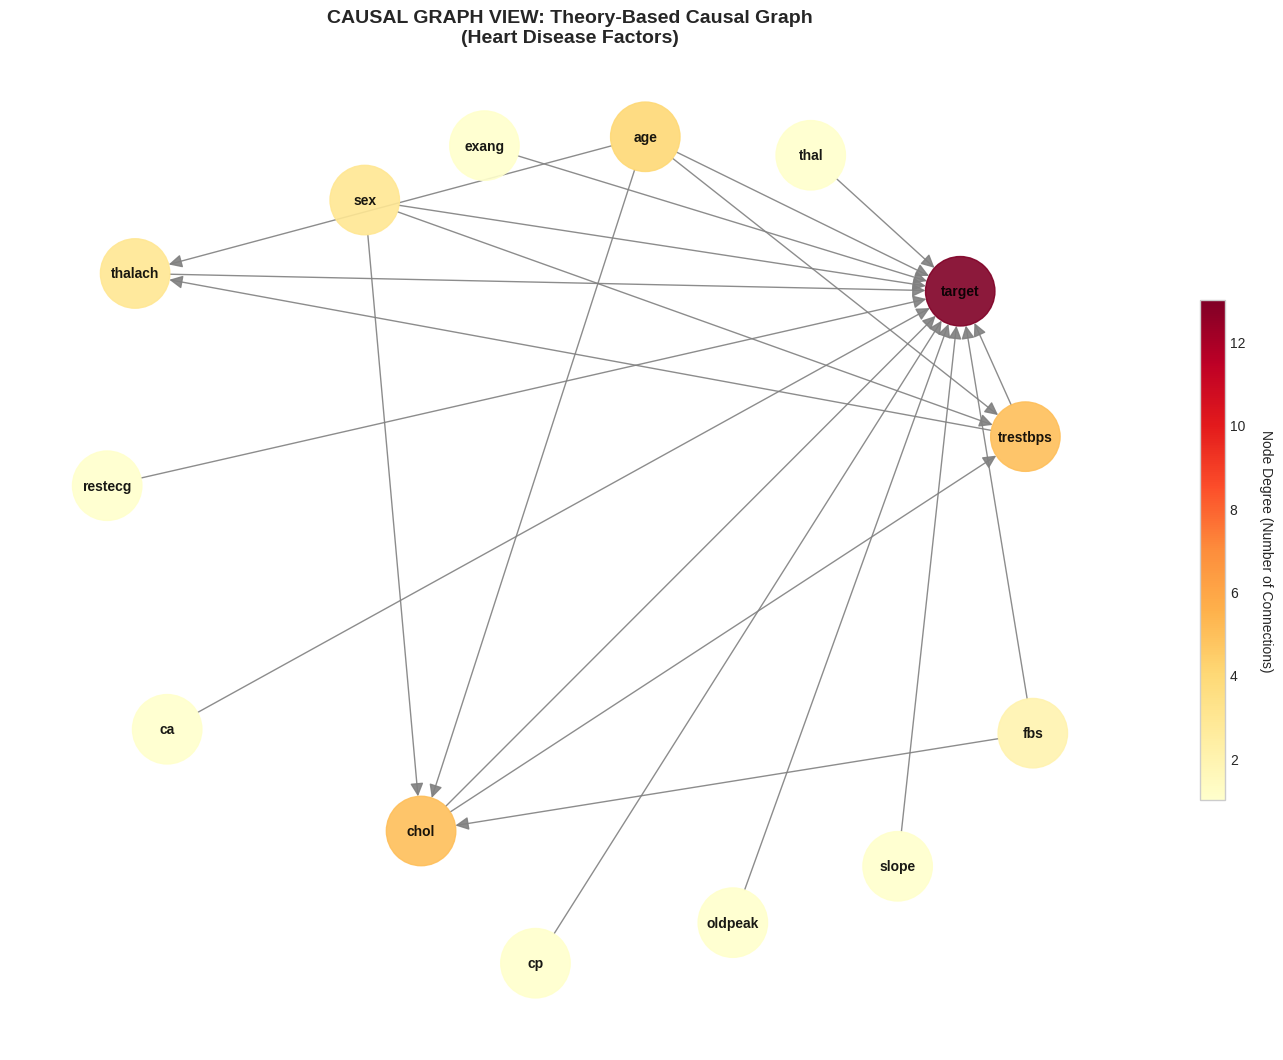


[Node Degree Statistics]
  target: Total=13, In=13, Out=0
  trestbps: Total=5, In=3, Out=2
  chol: Total=5, In=3, Out=2
  age: Total=4, In=0, Out=4
  thalach: Total=3, In=2, Out=1
  sex: Total=3, In=0, Out=3
  fbs: Total=2, In=0, Out=2
  cp: Total=1, In=0, Out=1
  exang: Total=1, In=0, Out=1
  oldpeak: Total=1, In=0, Out=1
  slope: Total=1, In=0, Out=1
  ca: Total=1, In=0, Out=1
  thal: Total=1, In=0, Out=1
  restecg: Total=1, In=0, Out=1


In [ ]:
# Cell 17: CAUSAL GRAPH VIEW - NetworkX Visualization
print("\n[1] Theory-Based Causal Graph (Static)")

# Create directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(14, 10))

# Layout
pos = nx.spring_layout(G, k=2, seed=42)

# Node colors based on degree (more connections = darker)
node_colors = [G.degree(n) for n in G.nodes()]

# Draw graph
nx.draw(G, pos,
        with_labels=True,
        node_color=node_colors,
        cmap=plt.cm.YlOrRd,
        node_size=2500,
        font_size=10,
        font_weight='bold',
        arrows=True,
        arrowsize=20,
        edge_color='gray',
        alpha=0.9)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd,
                           norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.5)
cbar.set_label('Node Degree (Number of Connections)', rotation=270, labelpad=20)

plt.title('CAUSAL GRAPH VIEW: Theory-Based Causal Graph\n(Heart Disease Factors)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print node statistics
print("\n[Node Degree Statistics]")
degree_dict = dict(G.degree())
sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
for node, degree in sorted_nodes:
    in_deg = G.in_degree(node)
    out_deg = G.out_degree(node)
    print(f"  {node}: Total={degree}, In={in_deg}, Out={out_deg}")

In [ ]:
# Cell 18: CAUSAL GRAPH VIEW - Interactive Plotly Visualization
print("\n[2] Interactive Causal Graph")

# Get positions
pos = nx.spring_layout(G, k=2, seed=42)

# Create edge traces
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create node traces
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_text = list(G.nodes())
node_size = [G.degree(node) * 5 + 20 for node in G.nodes()]
node_color = [G.degree(node) for node in G.nodes()]

# Create figure
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='gray'),
    hoverinfo='none'
))

# Add nodes
fig.add_trace(go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='YlOrRd',
        showscale=True,
        colorbar=dict(title='Node Degree')
    ),
    hovertemplate='<b>%{text}</b><br>Degree: %{marker.color}<extra></extra>'
))

fig.update_layout(
    title='CAUSAL GRAPH VIEW: Interactive Causal Graph',
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=600,
    hovermode='closest'
)

fig.show()


[2] Interactive Causal Graph



[3] DoWhy Causal Inference Model
Treatment: chol (Cholesterol Level)
Outcome: target (Heart Disease)
Confounders: ['age', 'sex', 'trestbps', 'fbs']

[Causal Model Graph]


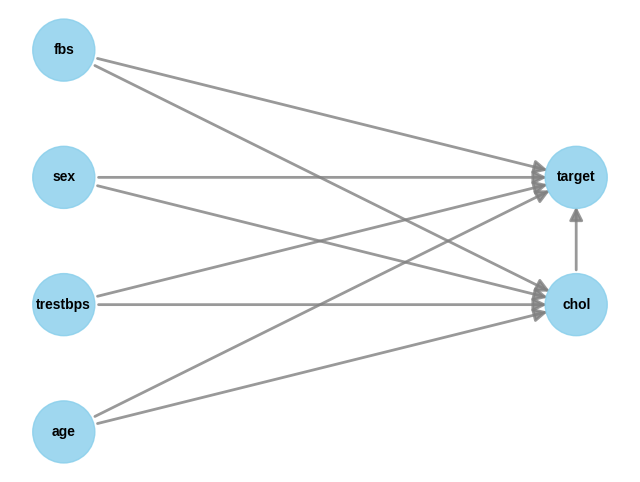

In [ ]:
# Cell 19: CAUSAL GRAPH VIEW - DoWhy Causal Model
print("\n[3] DoWhy Causal Inference Model")
print("="*60)

# Define causal model
treatment = 'chol'  # Kolesterol sebagai treatment
outcome = 'target'   # Penyakit jantung sebagai outcome
confounders = ['age', 'sex', 'trestbps', 'fbs']  # Confounders

print(f"Treatment: {treatment} (Cholesterol Level)")
print(f"Outcome: {outcome} (Heart Disease)")
print(f"Confounders: {confounders}")

# Create causal model
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders
)

# View model
print("\n[Causal Model Graph]")
model.view_model()
plt.show()

In [ ]:
# Cell 20: CAUSAL GRAPH VIEW - Identify & Estimate Causal Effect
print("\n[4] Causal Effect Estimation")
print("="*60)

# Identify causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("\n[Identified Estimand]")
print(identified_estimand)

# Estimate causal effect
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("\n" + "="*60)
print("HASIL ESTIMASI EFEK KAUSAL")
print("="*60)
print(f"\nCausal Effect (ATE): {estimate.value:.6f}")
print(f"\nInterpretasi:")
print(f"  Setiap kenaikan 1 mg/dl {treatment} (cholesterol)")
print(f"  menyebabkan perubahan {estimate.value:.6f} pada probabilitas {outcome} (heart disease)")
if estimate.value > 0:
    print(f"\n  → Kolesterol MENINGKATKAN risiko penyakit jantung")
else:
    print(f"\n  → Kolesterol MENURUNKAN risiko penyakit jantung")


[4] Causal Effect Estimation

[Identified Estimand]
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                   
───────(E[target|age,trestbps,sex,fbs])
d[chol]                                
Estimand assumption 1, Unconfoundedness: If U→{chol} and U→target then P(target|chol,age,trestbps,sex,fbs,U) = P(target|chol,age,trestbps,sex,fbs)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
   d                                   
───────(E[target|age,trestbps,sex,fbs])
d[chol]                                
Estimand assumption 1, Unconfoundedness: If U→{chol} and U→target then P(target|chol,age,trestbps,sex,fbs,U) = P(target|chol,age,trestbps,sex,fbs)


HASIL ESTIMASI EFEK KAUSAL

Causal Effect (ATE): -0.000868

Interpretasi:
  Setiap kenaikan 1 mg

In [ ]:
# Cell 21: CAUSAL GRAPH VIEW - Refutation Tests
print("\n[5] Refutation Tests (Validasi Hasil)")
print("="*60)

# Test 1: Random Common Cause
print("\n[Test 1] Random Common Cause")
refute_random = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="random_common_cause"
)
print(f"  Original Effect: {refute_random.estimated_effect:.6f}")
print(f"  New Effect: {refute_random.new_effect:.6f}")
diff1 = abs(refute_random.estimated_effect - refute_random.new_effect)
print(f"  Difference: {diff1:.6f}")
print(f"  Status: {'✓ ROBUST' if diff1 < 0.01 else '⚠ Perlu investigasi'}")

# Test 2: Placebo Treatment
print("\n[Test 2] Placebo Treatment")
refute_placebo = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)
print(f"  Original Effect: {refute_placebo.estimated_effect:.6f}")
print(f"  Placebo Effect: {refute_placebo.new_effect:.6f}")
print(f"  Status: {'✓ VALID (placebo effect ~0)' if abs(refute_placebo.new_effect) < 0.01 else '⚠ Placebo effect detected'}")


[5] Refutation Tests (Validasi Hasil)

[Test 1] Random Common Cause
  Original Effect: -0.000868
  New Effect: -0.000865
  Difference: 0.000004
  Status: ✓ ROBUST

[Test 2] Placebo Treatment
  Original Effect: -0.000868
  Placebo Effect: -0.000060
  Status: ✓ VALID (placebo effect ~0)


In [ ]:
# Cell 22: Additional Causal Analysis - Different Treatment
print("\n[6] Additional Causal Analysis: Blood Pressure → Heart Disease")
print("="*60)

# Model dengan treatment berbeda
treatment2 = 'trestbps'
confounders2 = ['age', 'sex', 'chol', 'fbs']

print(f"Treatment: {treatment2} (Resting Blood Pressure)")
print(f"Outcome: {outcome} (Heart Disease)")
print(f"Confounders: {confounders2}")

model2 = CausalModel(
    data=df,
    treatment=treatment2,
    outcome=outcome,
    common_causes=confounders2
)

identified2 = model2.identify_effect(proceed_when_unidentifiable=True)
estimate2 = model2.estimate_effect(identified2, method_name="backdoor.linear_regression")

print(f"\nCausal Effect (ATE): {estimate2.value:.6f}")
print(f"\nInterpretasi:")
print(f"  Setiap kenaikan 1 mm Hg tekanan darah")
print(f"  menyebabkan perubahan {estimate2.value:.6f} pada probabilitas penyakit jantung")


[6] Additional Causal Analysis: Blood Pressure → Heart Disease
Treatment: trestbps (Resting Blood Pressure)
Outcome: target (Heart Disease)
Confounders: ['age', 'sex', 'chol', 'fbs']

Causal Effect (ATE): -0.002851

Interpretasi:
  Setiap kenaikan 1 mm Hg tekanan darah
  menyebabkan perubahan -0.002851 pada probabilitas penyakit jantung


---
## 6. RINGKASAN ANALISIS

In [ ]:
# Cell 23: Summary
print("="*60)
print("RINGKASAN ANALISIS")
print("="*60)

print(f"""
DATASET:
  • Nama: Heart Disease UCI Dataset
  • Sumber: Kaggle / UCI Machine Learning Repository
  • Jumlah Data: {len(df)} records
  • Jumlah Variabel: {len(df.columns)} columns

DIMENSION VIEW:
  • Distribusi {len(numerical_cols)} variabel numerik
  • Distribusi {len(categorical_cols)} variabel kategorikal
  • Correlation heatmap
  • Boxplot comparison by target
  • 3D interactive visualization

TABLE VIEW:
  • Statistik deskriptif
  • Crosstab analysis
  • Correlation matrix
  • Mean comparison by disease status

CAUSAL GRAPH VIEW:
  • {len(edges)} causal edges teridentifikasi
  • Theory-based DAG visualization
  • Interactive causal graph
  • DoWhy causal inference

CAUSAL INFERENCE RESULTS:
  • Treatment 1: {treatment} (Cholesterol)
    - Outcome: {outcome}
    - Estimated ATE: {estimate.value:.6f}

  • Treatment 2: {treatment2} (Blood Pressure)
    - Outcome: {outcome}
    - Estimated ATE: {estimate2.value:.6f}

""")
print("ANALISIS SELESAI")
print("="*60)

RINGKASAN ANALISIS

DATASET:
  • Nama: Heart Disease UCI Dataset
  • Sumber: Kaggle / UCI Machine Learning Repository
  • Jumlah Data: 302 records
  • Jumlah Variabel: 14 columns

DIMENSION VIEW:
  • Distribusi 5 variabel numerik
  • Distribusi 8 variabel kategorikal
  • Correlation heatmap
  • Boxplot comparison by target
  • 3D interactive visualization

TABLE VIEW:
  • Statistik deskriptif
  • Crosstab analysis
  • Correlation matrix
  • Mean comparison by disease status

CAUSAL GRAPH VIEW:
  • 21 causal edges teridentifikasi
  • Theory-based DAG visualization
  • Interactive causal graph
  • DoWhy causal inference

CAUSAL INFERENCE RESULTS:
  • Treatment 1: chol (Cholesterol)
    - Outcome: target
    - Estimated ATE: -0.000868
  
  • Treatment 2: trestbps (Blood Pressure)
    - Outcome: target
    - Estimated ATE: -0.002851


ANALISIS SELESAI
